# Masking Useful Data

In this notebook, we attempt to create an image preprocessing tool for the hyperspectral "crate" data. The tool classifies clusters of rocks that we label by hand for a single image and test on other images. The model procedure is as follows:

1. PCA dimensionality reduction and unit scaling.
2. K-Means clustering
3. labeling by hand.
4. Neural network classifier.

PCA is used because K-Means tends to perform poorly on high-dimensional data, and kmeans is known to perform best when all axes are similarly scaled. A small number of clusters appeared to work best by visual inspection. A neural network was used to accomodate the large scale of the data (~180k samples per image) for creating a classifier that accomodated both the information from clustering and pre-provided mask.

In [1]:
import spectral as sp
import spectral.io.envi as envi

import numpy as np
import scipy as sc

import pandas as pd

import sklearn
import skimage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
# sns.set()

import joblib

## Load and Visualize the Data

__note:__ The header files as provided are missing a line that is required for loading the file with the spectral library. Be sure to add the line:

```
byte order = 0
```

anywhere after the first line. Please see the [ENVI header file documentation](https://www.harrisgeospatial.com/docs/ENVIHeaderFiles.html).

In [2]:
img = envi.open("data/VNIR and SWIR interval/CMM-111_195_extracted_image.hdr", "data/VNIR and SWIR interval/CMM-111_195_extracted_image.img")

In [3]:
hypr_c195 = img.load()
hypr_shape = hypr_c195.shape
print(f"image shape: {hypr_shape}")
wavelengths = np.array(img.bands.centers)
print(f"wavelength range: {(wavelengths[0], wavelengths[-1])}")

image shape: (527, 337, 411)
wavelength range: (463.31, 2476.54)


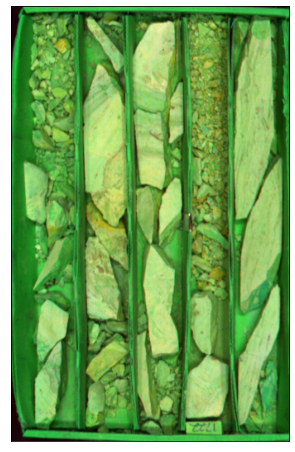

In [4]:
plt.figure(figsize=(10,8))
plt.imshow(sp.get_rgb(hypr_c195))
plt.xticks([])
plt.yticks([])
plt.show()

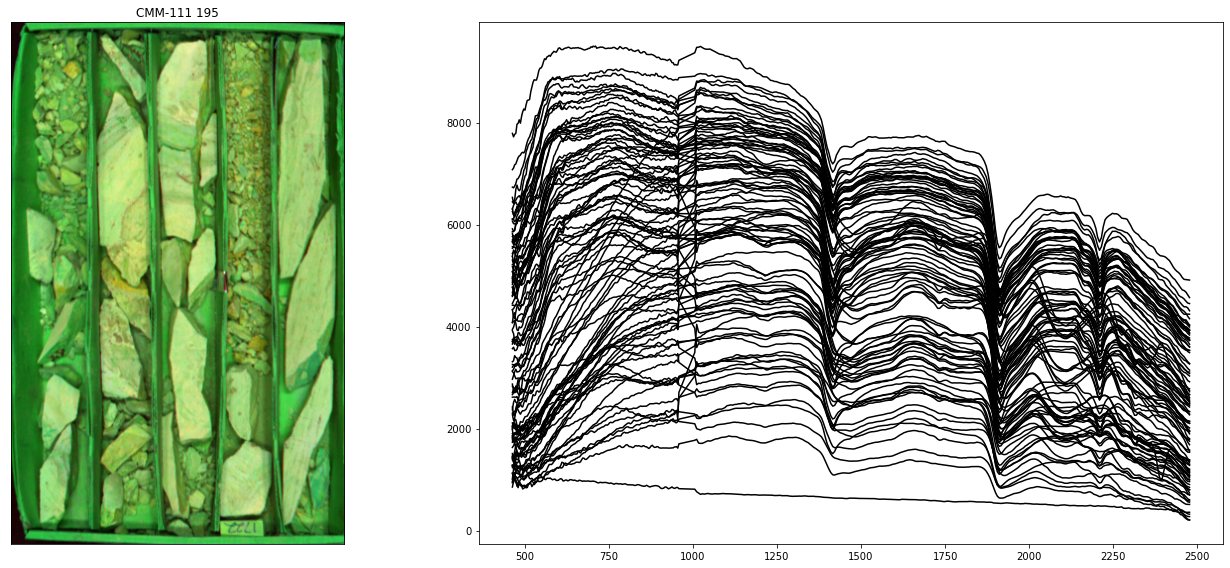

In [5]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
img_rgb = sp.get_rgb(img)
plt.imshow(img_rgb)
plt.title("CMM-111 195")
plt.xticks([]); plt.yticks([])

plt.subplot(1,2,2)
plt.plot(
    wavelengths,
    pd.DataFrame(hypr_c195.reshape(-1,411)).sample(100).values.T,
    '-k'
)

plt.tight_layout()
plt.show()

## Mask Provided
We have also been provided a mask that indicates the regions of interest. However, this mask only erases the crate itself and does not filter out the gravel which is not usable. Nevertheless, it is still valuable for preprocessing.

In [6]:
mask_c195 = plt.imread('data/Core Mask/VN-SWIR_Core_Mask_CMM-111_195@1719_1726.tiff')
mask_c195 = rgb2gray(mask_c195).astype(bool)

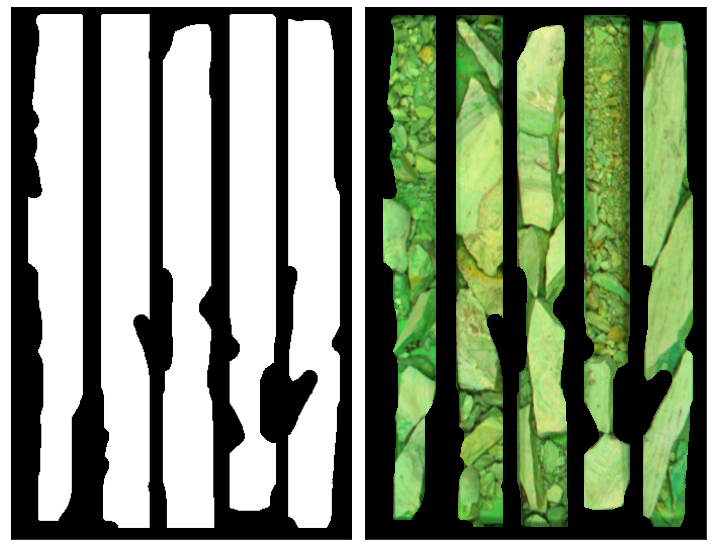

In [7]:
plt.figure(figsize=(10,16))
plt.subplot(1,2,1)
plt.imshow(mask_c195, cmap='binary_r')
plt.xticks([]); plt.yticks([])

plt.subplot(1,2,2)
abc = img_rgb.copy()
abc[~mask_c195,:] = np.nan
plt.imshow(abc)
plt.xticks([]); plt.yticks([])

plt.tight_layout()
plt.show()

In [8]:
hypr = hypr_c195[mask_c195,:] ## we select only the white parts of the mask
hypr = hypr.reshape(-1, 411)

## PCA + K-Means
good old fashioned clustering

We can optionally exclude the VNIR data, that is, include only the SWIR data. We can not necessarily justify this, however, this seems to work well.

In [9]:
swir_range, = np.where(wavelengths >= 1000)
hypr = hypr[:,swir_range]

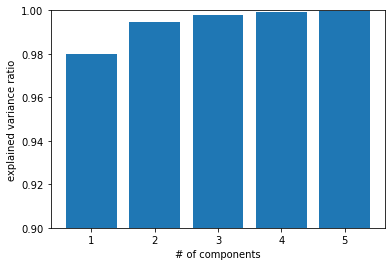

[0.9800875  0.99486464 0.998059   0.99923414 0.9995195 ]
[5333.578    654.9123   304.49408  184.68497   91.01486]


In [10]:
pca = TruncatedSVD(n_components=5)
pl  = Pipeline([('scale',StandardScaler()),('pca',pca)])
hyprT = pl.fit_transform(hypr)

plt.bar(np.arange(1,5+1),
        np.cumsum(pca.explained_variance_ratio_),
        )
plt.xlabel('# of components')
plt.ylabel('explained variance ratio')
plt.ylim([0.9,1])
plt.show()

print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

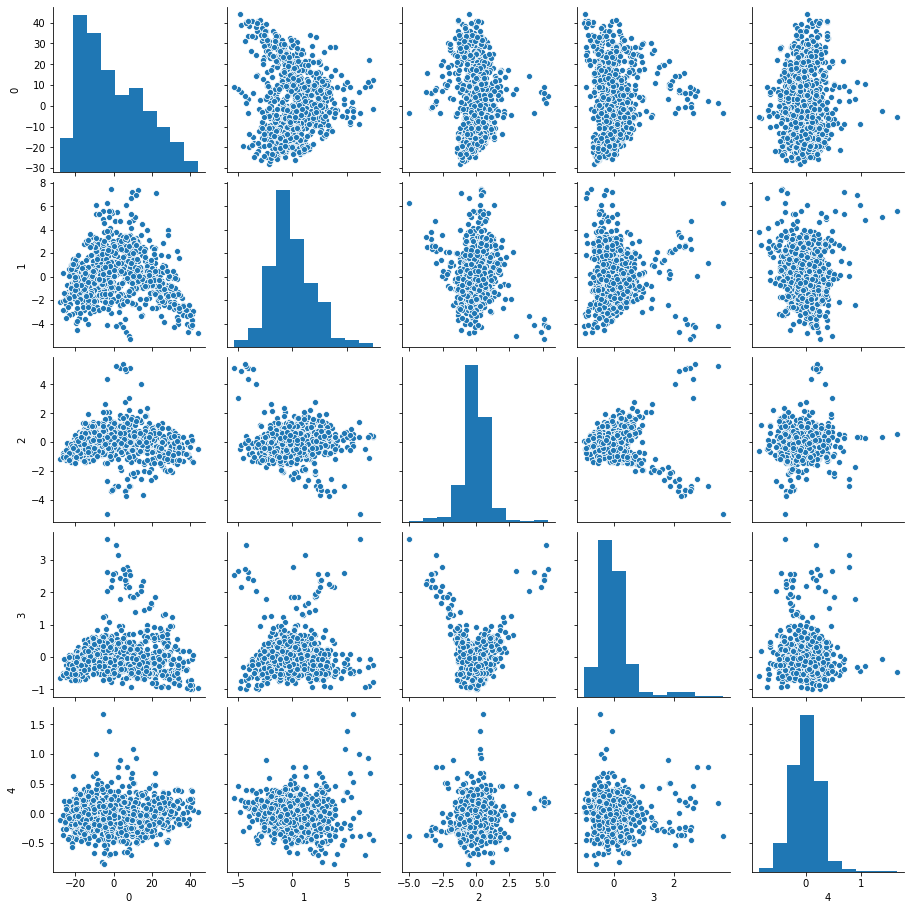

In [11]:
sns.pairplot(pd.DataFrame(hyprT).sample(1000))
plt.show()

In [12]:
n_clusters = 2
kM = KMeans(n_clusters=n_clusters, random_state=1234) # random_state for reproducability

In [13]:
H = hypr_c195.reshape(-1, 411)
H = H[:,swir_range]
H = pl.transform(H)
labels = kM.fit_predict(H)

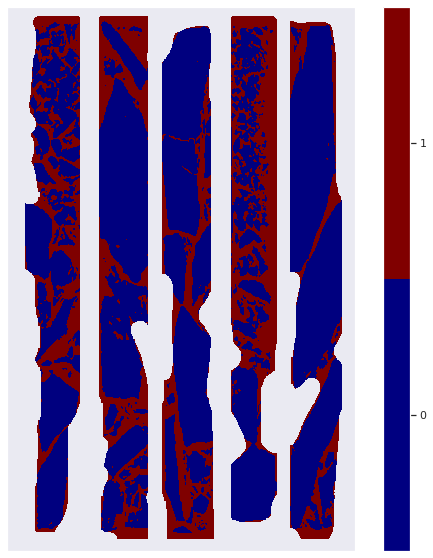

In [14]:
im_labels = labels.reshape(hypr_shape[:2]).astype(float)
im_labels[~mask_c195] = np.nan

v = cm.get_cmap('jet', n_clusters)

plt.figure(figsize=(10,10))
sns.set()
# plt.subplot(1,2,1)
# plt.imshow(img_rgb)
# plt.xticks([])
# plt.yticks([])

# plt.subplot(1,2,2)
plt.imshow(im_labels, cmap=v, vmin=-0.5, vmax=n_clusters-0.5)
plt.colorbar(ticks=np.arange(0,n_clusters))#, shrink=0.3)
plt.xticks([])
plt.yticks([])

# plt.tight_layout()
plt.show()

In [15]:
## visual inspection of valid clusters, label them here
clusters = [0,]

In [16]:
y = (labels == clusters[0])
for i in range(1, len(clusters)):
    y = np.logical_or(y, labels == clusters[i])

In [17]:
y = np.logical_and(y, mask_c195.reshape(-1)) # require that the selected clusters fall in the valid range

In [18]:
df = pd.DataFrame(H)
df['label'] = y

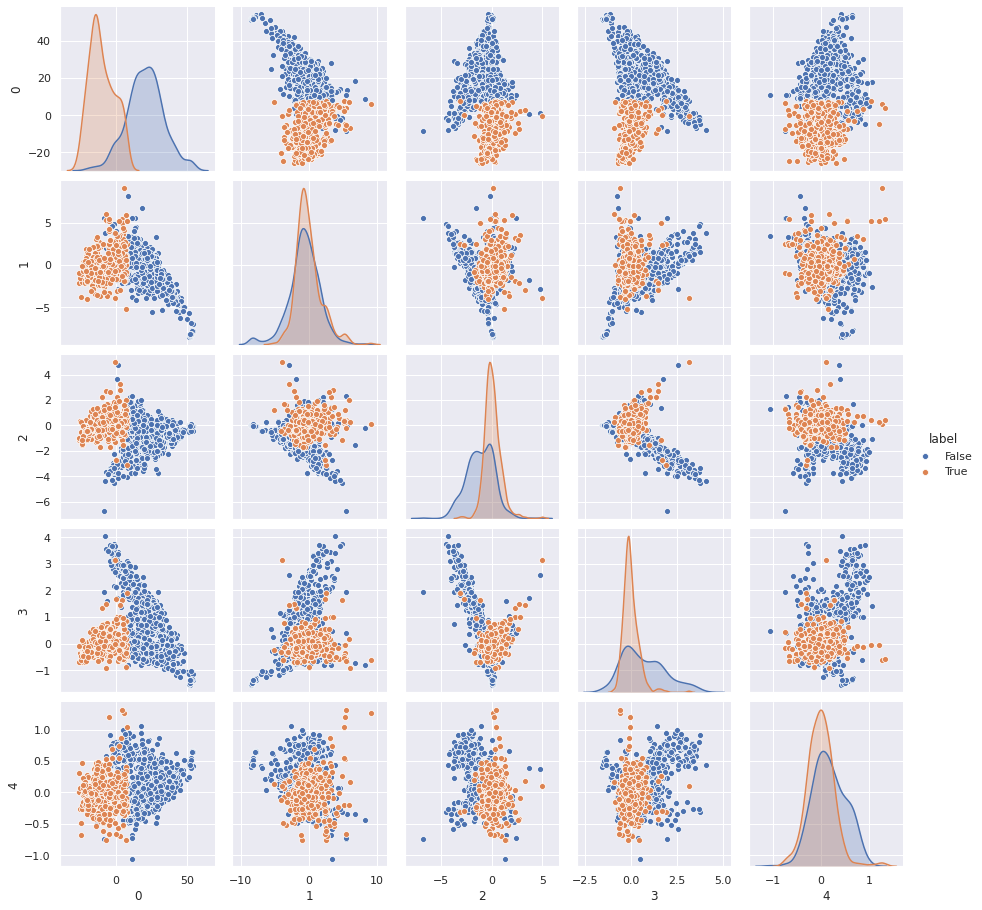

In [19]:
sns.pairplot(df.sample(1000), hue='label')
plt.show()

In [34]:
H1 = H[y]

In [35]:
nc1 = 6
km1 = KMeans(n_clusters=nc1)
km1.fit(H1)

KMeans(n_clusters=6)

In [36]:
y1 = km1.predict(H).astype(float)
# y1[~y] = np.nan

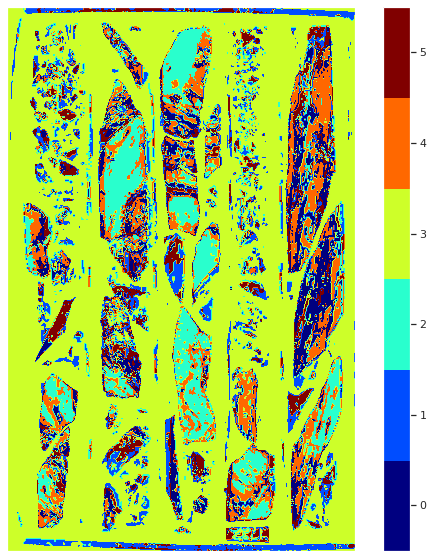

In [37]:
plt.figure(figsize=(10,10))
v1 = cm.get_cmap('jet', nc1)
plt.imshow(y1.reshape(hypr_shape[:2]), cmap=v1, vmin=-0.5, vmax=nc1-0.5)
plt.colorbar(ticks=np.arange(0,nc1))#, shrink=0.3)
plt.xticks([])
plt.yticks([])
plt.show()

## Classification
Now we construct a general classifier as applied to the entire image, now labeled. 

In [ ]:
clf = MLPClassifier(alpha=1e-4,verbose=True)
clf.fit(H,y);

In [ ]:
yHat = clf.predict(H)

In [ ]:
plt.figure(figsize=(10,16))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(yHat.reshape(hypr_shape[:2]), cmap='binary_r')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

## Validate on Another Image
The `Masker` class takes in all the work we've done above and allows us to plug in any new image to get a mask for that image.

The model pipeline is essentially all the preprocessing steps + the classifier we've constructed, i.e. PCA + scaling + neural network all conviniently combined using the `Pipeline` class from sklearn. We also provide the SWIR range because we have truncated the range of relevance to only SWIR wavelengths. If we comment that part of the code above, we can simply not provide a range at all, and the class will interpret that to mean the entire range.

In [ ]:
from source.hyperspectrum_models import Masker
help(Masker)

In [ ]:
preproc = Masker(
    Pipeline([("preprocc",pl),("classifier",clf)]),
    swir_range
)

In [ ]:
img = envi.open("data/VNIR and SWIR interval/CMM-111_196_extracted_image.hdr", "data/VNIR and SWIR interval/CMM-111_196_extracted_image.img")
img = img.load()

In [ ]:
yHat = preproc(img) # the Masker class is callable and just needs an array of shape [x,y, 411] where x,y are any ints

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sp.get_rgb(img))
plt.xticks([])
plt.yticks([])

plt.subplot(1,2,2)
plt.imshow(yHat, cmap='binary_r')
plt.xticks([])
plt.yticks([])

# plt.suptitle("CMM-111 196")
plt.tight_layout()
plt.show()

In [ ]:
joblib.dump(preproc, 'binaries/masker.joblib') # we save our Masker model for reusing at a later date.